In [ ]:
#Imports
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
#loading model
model = load_model("/content/drive/MyDrive/multilabel_cnn_improved.keras")

In [ ]:
#Parameters (MATCH TRAINING)
SR = 16000

SEGMENT_DURATION = 2.0
HOP_DURATION = 1.0

SEGMENT_SAMPLES = int(SEGMENT_DURATION * SR)
HOP_SAMPLES = int(HOP_DURATION * SR)

N_MELS = 128
HOP_LENGTH = 512
IMG_SIZE = 128

In [ ]:
#Segment Audio
def segment_audio(audio):
    segments = []
    times = []
    for start in range(0, len(audio) - SEGMENT_SAMPLES + 1, HOP_SAMPLES):
        segments.append(audio[start:start + SEGMENT_SAMPLES])
        times.append(start / SR)
    return segments, times

In [ ]:
#Segment → Mel
def segment_to_mel(segment):
    mel = librosa.feature.melspectrogram(
        y=segment,
        sr=SR,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = tf.image.resize(
        mel_db[..., np.newaxis],
        (IMG_SIZE, IMG_SIZE)
    ).numpy()

    mel_db = np.repeat(mel_db, 3, axis=-1)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    return mel_db

In [ ]:
#Generate Segment Predictions
def predict_timeline(audio_path):
    audio, _ = librosa.load(audio_path, sr=SR, mono=True)

    segments, times = segment_audio(audio)

    probs_over_time = []

    for seg in segments:
        mel = segment_to_mel(seg)
        mel = np.expand_dims(mel, axis=0)
        probs = model.predict(mel, verbose=0)[0]
        probs_over_time.append(probs)

    return np.array(probs_over_time), times

In [ ]:
#uploading file
from google.colab import files

uploaded = files.upload()
print(uploaded.keys())

Saving (1) - 03 - Alexandre Lagoya - Canarios (Sanz)-1.wav to (1) - 03 - Alexandre Lagoya - Canarios (Sanz)-1.wav
dict_keys(['(1) - 03 - Alexandre Lagoya - Canarios (Sanz)-1.wav'])


In [ ]:
#Choose Audio Clip
TEST_AUDIO = "/content/(1) - 03 - Alexandre Lagoya - Canarios (Sanz)-1.wav"
segment_probs, times = predict_timeline(TEST_AUDIO)

print("Segment probabilities shape:", segment_probs.shape)

Segment probabilities shape: (19, 11)


In [ ]:
#Smooth Segment Predictions
#Moving Average Smoothing
def smooth_predictions(preds, window=3):
    smoothed = np.zeros_like(preds)
    for i in range(preds.shape[1]):  # for each instrument
        smoothed[:, i] = np.convolve(
            preds[:, i],
            np.ones(window)/window,
            mode="same"
        )
    return smoothed

smoothed_probs = smooth_predictions(segment_probs, window=3)

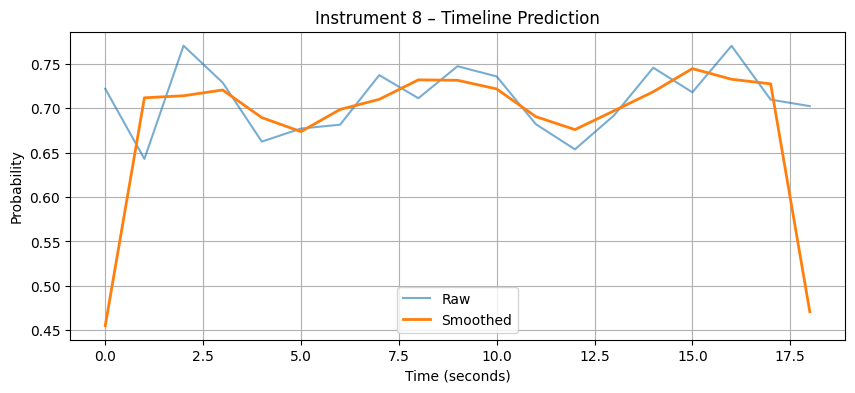

In [ ]:
#Timeline Plot
#Plot for ONE instrument
INSTRUMENT_IDX = 8  # change if needed

plt.figure(figsize=(10,4))
plt.plot(times, segment_probs[:, INSTRUMENT_IDX], label="Raw", alpha=0.6)
plt.plot(times, smoothed_probs[:, INSTRUMENT_IDX], label="Smoothed", linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Probability")
plt.title(f"Instrument {INSTRUMENT_IDX} – Timeline Prediction")
plt.legend()
plt.grid(True)
plt.show()

# **Conclusion**
In this experiment, the trained multilabel CNN model was applied to segmented audio clips to generate time-wise instrument prediction probabilities. Segment-level predictions were smoothed using a moving average to reduce fluctuations and improve temporal consistency. The resulting timeline plot provides a clear visualization of how instrument presence evolves over time, demonstrating the model's ability to capture temporal patterns in audio signals.